### Importing the Libraries

In [57]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

## Loading the data

Defining a function to load the data in sorted order

In [37]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

* First we will load the filenames in a list.  
* Then we will open each filename as an Image and convert it to numpy array and create list of such numpy arrays.
* Same will be done for both Feature Images and Label Images

In [38]:
filelist_trainx_ph2 = sorted(glob.glob('ph2_resized2/trainx/*.bmp'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('ph2_resized2/trainy/*.bmp'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

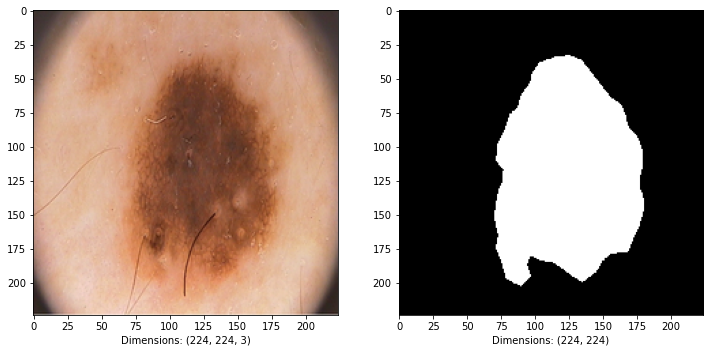

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[0]).shape))
plt.show()


We can observe that the images are of dimensions **(572, 765)** so we will scale dow the images. It will also reduce the training time of the network.

#### Resizing

In [40]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

In [41]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx_ph2)):
    X_train_ph2_resized.append(resize(filelist_trainx_ph2[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy_ph2[i]))    

Let us check the new images

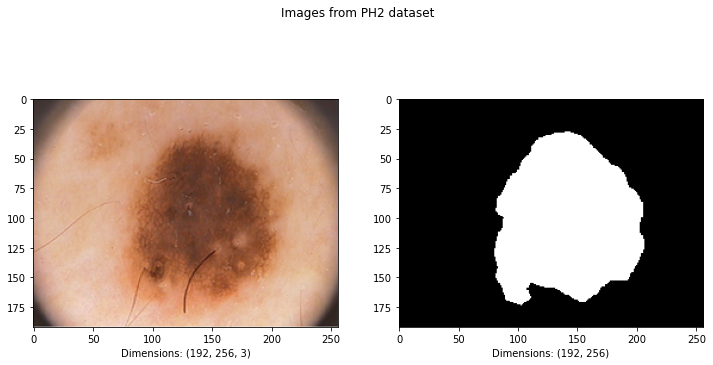

In [42]:
plt.figure(figsize=(12,6))
plt.suptitle("Images from PH2 dataset")
plt.subplot(1,2,1)
plt.imshow(X_train_ph2_resized[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2_resized[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2_resized[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2_resized[0]).shape))
plt.show()

Converting the transformed Images into numpy arrays

In [43]:
X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

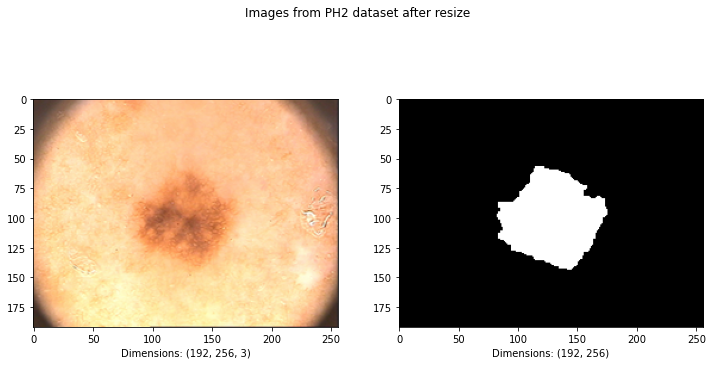

In [44]:
plt.figure(figsize=(12,6))
plt.suptitle("Images from PH2 dataset after resize")
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[123])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2_resized[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[123], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2_resized[0]).shape))
plt.show()

Splitting the dataset into training set and test set to verify our model performance without any bias.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)

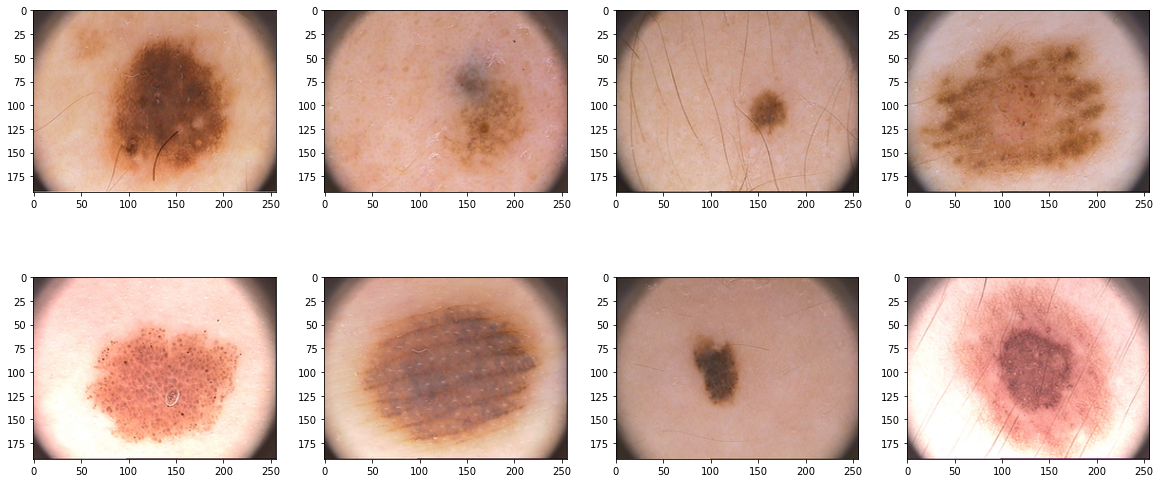

In [12]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train_ph2[0])
plt.subplot(2,4,2)
plt.imshow(X_train_ph2[3])
plt.subplot(2,4,3)
plt.imshow(X_train_ph2[54])
plt.subplot(2,4,4)
plt.imshow(X_train_ph2[77])
plt.subplot(2,4,5)
plt.imshow(X_train_ph2[100])
plt.subplot(2,4,6)
plt.imshow(X_train_ph2[125])
plt.subplot(2,4,7)
plt.imshow(X_train_ph2[130])
plt.subplot(2,4,8)
plt.imshow(X_train_ph2[149])
plt.show()

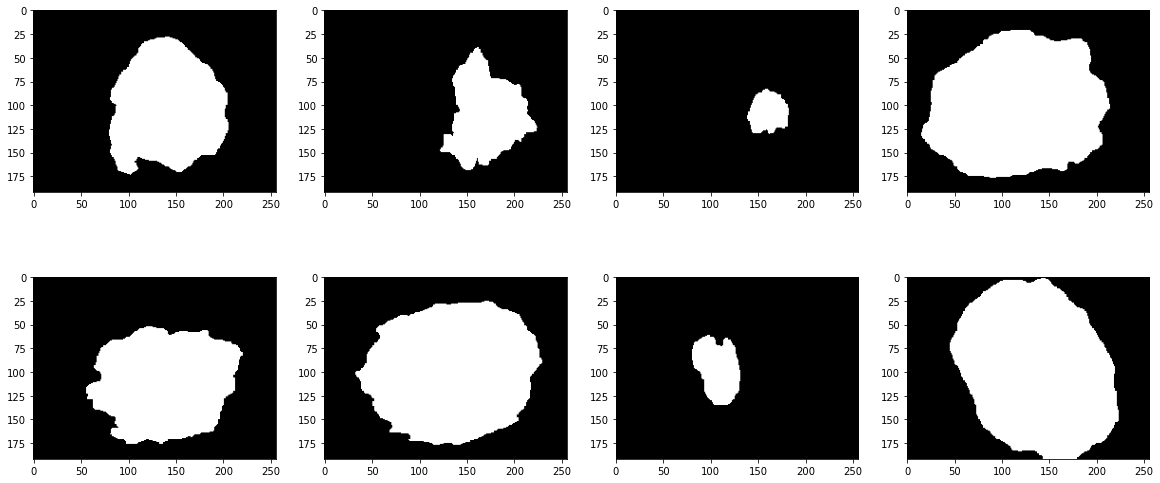

In [13]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train_ph2[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train_ph2[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train_ph2[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train_ph2[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train_ph2[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train_ph2[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train_ph2[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train_ph2[149], cmap = plt.cm.binary_r)
plt.show()

### Unet Loss Function

#### Jaccard Distance

In [14]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

## Defining Evaluation Metrics

#### Intersection over Union
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![i](https://www.d2l.ai/_images/iou.svg)

In [15]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### Dice Coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![i](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [16]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Precision
Precision is a good measure to determine, when the costs of False Positive is high

![i](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [18]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#### Recall
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative

![i](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [19]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#### Accuracy

In [20]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Image Augmentation

To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for **random rotation** and one for **horizontal flipping**

In [21]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return np.array(x_image), np.array(y_image.astype('int'))

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [22]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

calling the functions for the training data.

In [23]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

Let us have a look at our transformations.

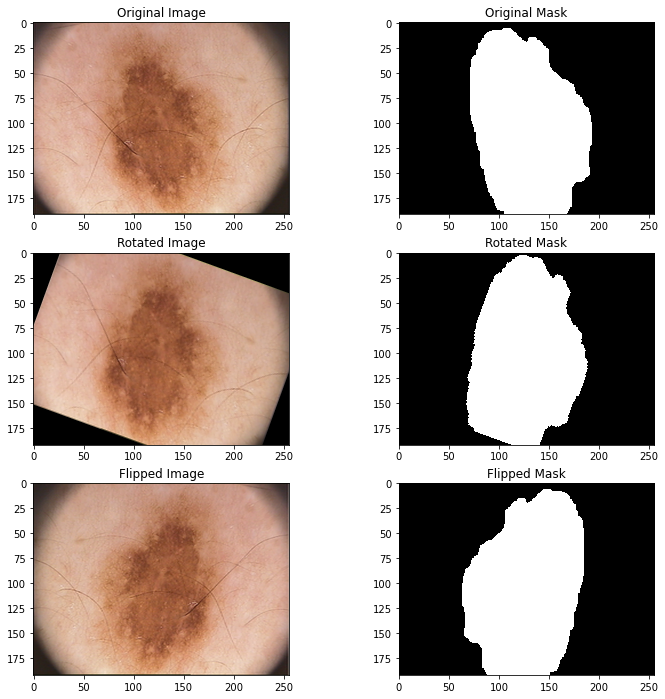

In [24]:
img_num = 112
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

Now we join all the augmentations image arrays to the original training arrays.

In [25]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

#### Making a Validation Set

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [27]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


We will split our full training set into train and validation set.  
Validation dataset is used to validate the performance after each epoch

## The Model



### Segnet Model

![i](graphics/seg_net.png)

* The above network is a variation of the architecture proposed [here](https://arxiv.org/pdf/1511.00561.pdf), we have customised it for our problem of lesion segmentation.
* The advised parameters can't exactly be applied to our problem.
* We will switch the final activation function from **Softmax** to **Sigmoid** as using softmax was producing blank dark images.
* The loss function in segnet is suggested **categorical crossentropy** due to it's genral use of multiclass segmentation problem but in our case we only have 1 class i.e. the melanoma. So, we will use **binary crossentropy**.

### Unet Model

In [28]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [29]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 192, 256))
        axis = 1
    else:
        inputs = Input((192, 256, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((192, 256))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [ ]:
model, hist = UNET(epochs_num= 100, savename= 'unet_100_epoch.h5')

In [29]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [30]:
model_2, hist_2 = segnet(100, 'segnet_100_epoch.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_24 (Activation)   (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_25 (Activation)   (None, 192, 256, 64)      0   

Train on 360 samples, validate on 90 samples
Epoch 1/100
360/360 [==============================] - 19s 54ms/step - loss: 0.7152 - iou: 0.6895 - dice_coef: 0.4290 - precision: 0.4186 - recall: 0.5593 - accuracy: 0.6058 - val_loss: 0.6698 - val_iou: 0.6853 - val_dice_coef: 0.3721 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6872
Epoch 2/100
360/360 [==============================] - 11s 29ms/step - loss: 0.5138 - iou: 0.7717 - dice_coef: 0.5244 - precision: 0.6839 - recall: 0.7502 - accuracy: 0.8034 - val_loss: 0.6426 - val_iou: 0.6976 - val_dice_coef: 0.3525 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6872
Epoch 3/100
360/360 [==============================] - 11s 29ms/step - loss: 0.4571 - iou: 0.8014 - dice_coef: 0.5612 - precision: 0.7754 - recall: 0.8157 - accuracy: 0.8622 - val_loss: 0.6292 - val_iou: 0.7057 - val_dice_coef: 0.3328 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6872
Epoch 4/100
360/360 [=

Epoch 28/100
360/360 [==============================] - 11s 29ms/step - loss: 0.2324 - iou: 0.9223 - dice_coef: 0.7303 - precision: 0.9264 - recall: 0.9364 - accuracy: 0.9545 - val_loss: 0.2445 - val_iou: 0.9156 - val_dice_coef: 0.7191 - val_precision: 0.8979 - val_recall: 0.9168 - val_accuracy: 0.9408
Epoch 29/100
360/360 [==============================] - 11s 29ms/step - loss: 0.2296 - iou: 0.9232 - dice_coef: 0.7326 - precision: 0.9266 - recall: 0.9371 - accuracy: 0.9547 - val_loss: 0.2520 - val_iou: 0.9117 - val_dice_coef: 0.7225 - val_precision: 0.8660 - val_recall: 0.9395 - val_accuracy: 0.9352
Epoch 30/100
360/360 [==============================] - 11s 29ms/step - loss: 0.2226 - iou: 0.9270 - dice_coef: 0.7383 - precision: 0.9317 - recall: 0.9403 - accuracy: 0.9581 - val_loss: 0.2326 - val_iou: 0.9219 - val_dice_coef: 0.7309 - val_precision: 0.9037 - val_recall: 0.9280 - val_accuracy: 0.9463
Epoch 31/100
360/360 [==============================] - 11s 29ms/step - loss: 0.2212 - i

Epoch 55/100
360/360 [==============================] - 11s 29ms/step - loss: 0.1676 - iou: 0.9503 - dice_coef: 0.7975 - precision: 0.9433 - recall: 0.9556 - accuracy: 0.9669 - val_loss: 0.2115 - val_iou: 0.9298 - val_dice_coef: 0.7678 - val_precision: 0.8752 - val_recall: 0.9416 - val_accuracy: 0.9390
Epoch 56/100
360/360 [==============================] - 11s 29ms/step - loss: 0.1651 - iou: 0.9515 - dice_coef: 0.7994 - precision: 0.9490 - recall: 0.9537 - accuracy: 0.9681 - val_loss: 0.1937 - val_iou: 0.9379 - val_dice_coef: 0.7808 - val_precision: 0.9047 - val_recall: 0.9342 - val_accuracy: 0.9484
Epoch 57/100
360/360 [==============================] - 10s 29ms/step - loss: 0.1666 - iou: 0.9506 - dice_coef: 0.7981 - precision: 0.9422 - recall: 0.9545 - accuracy: 0.9667 - val_loss: 0.1911 - val_iou: 0.9395 - val_dice_coef: 0.7790 - val_precision: 0.9115 - val_recall: 0.9326 - val_accuracy: 0.9504
Epoch 58/100
360/360 [==============================] - 10s 29ms/step - loss: 0.1626 - i

Epoch 82/100
360/360 [==============================] - 11s 29ms/step - loss: 0.1337 - iou: 0.9633 - dice_coef: 0.8341 - precision: 0.9608 - recall: 0.9601 - accuracy: 0.9744 - val_loss: 0.1704 - val_iou: 0.9467 - val_dice_coef: 0.8095 - val_precision: 0.9128 - val_recall: 0.9375 - val_accuracy: 0.9521
Epoch 83/100
360/360 [==============================] - 11s 29ms/step - loss: 0.1344 - iou: 0.9627 - dice_coef: 0.8351 - precision: 0.9563 - recall: 0.9625 - accuracy: 0.9734 - val_loss: 0.1687 - val_iou: 0.9476 - val_dice_coef: 0.8080 - val_precision: 0.9265 - val_recall: 0.9276 - val_accuracy: 0.9538
Epoch 84/100
360/360 [==============================] - 10s 29ms/step - loss: 0.1360 - iou: 0.9620 - dice_coef: 0.8329 - precision: 0.9506 - recall: 0.9639 - accuracy: 0.9725 - val_loss: 0.1724 - val_iou: 0.9460 - val_dice_coef: 0.8071 - val_precision: 0.9135 - val_recall: 0.9343 - val_accuracy: 0.9512
Epoch 85/100
360/360 [==============================] - 10s 29ms/step - loss: 0.1383 - i

### Plotting Training Statistics

In [ ]:
plt.figure(figsize=(14, 35))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(8,2,1)
plt.plot(hist_2.history['loss'], 'red')
plt.title('Training Loss for SegNet')
plt.subplot(8,2,2)
plt.plot(hist_2.history['accuracy'], 'green')
plt.title('Training Accuracy for SegNet')
plt.subplot(8,2,5)
plt.plot(hist.history['loss'], 'red')
plt.title('Training Loss for Unet')
plt.subplot(8,2,6)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Training Accuracy for Unet')
plt.subplot(8,2,3)
plt.plot(hist_2.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss for SegNet')
plt.subplot(8,2,4)
plt.plot(hist_2.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy for SegNet')
plt.subplot(8,2,7)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss for Unet')
plt.subplot(8,2,8)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy for Unet')
plt.show()

## Loading the models for evaluation

#### For Unet

In [52]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 192, 256))
    axis = 1
else:
    inputs = Input((192, 256, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((192, 256))(conv_final)

In [53]:
model_unet = Model(inputs, pred, name="UNET")
model_unet.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])

In [54]:
model_unet.load_weights('unet_100_epoch.h5')

#### For SegNet

In [55]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer 
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [58]:
model_segnet = Model(inputs=img_input, outputs=pred)

model_segnet.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [59]:
model_segnet.load_weights('segnet_100_epoch.h5')

In [60]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res_unet = model_unet.evaluate(x_train, y_train, batch_size= 18)
res_segnet = model_segnet.evaluate(x_train, y_train, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res_unet = model_unet.evaluate(x_test, y_test, batch_size= 18)
res_segnet = model_segnet.evaluate(x_test, y_test, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res_unet = model_unet.evaluate(x_val, y_val, batch_size= 18)
res_segnet = model_segnet.evaluate(x_val, y_val, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 134s 7s/step - loss: 0.1168 - iou: 0.9695 - dice_coef: 0.8501 - precision: 0.9544 - recall: 0.9775 - accuracy: 0.9782
_______________SegNet_____Unet____
IOU:       |   96.95  |   92.27  |
Dice Coef: |   85.01  |   86.93  |
Precision: |   95.44  |   88.24  |
Recall:    |   97.75  |   88.02  |
Accuracy:  |   97.82  |   92.47  |
Loss:      |   11.68  |   7.73  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 19s 5s/step - loss: -177.1943 - iou: 0.2872 - dice_coef: 1.7260 - precision: 0.9305 - recall: 1.0000 - accuracy: 0.6414
_______________SegNet_____Unet____
IOU:       |   28.72  |   28.26  |
Dice Coef: |   172.60  |   174.91  |
Precision: |   93.05  |   91.96  |
Recall:    |   100.00  |   97.61  |
Accuracy:  |   64.14  |   63.05  |
Loss:      |   -17719.43  |   71.74

### Visualising Predicted Lesions

We have trained the model on the **training set**.  
We will make predictions on the unseen **test set**

1/1 [==============================] - 1s 935ms/step


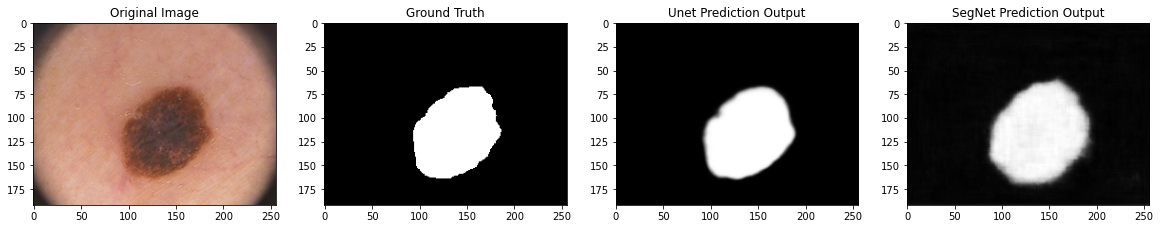

In [61]:
img_num = 49
img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

1/1 [==============================] - 0s 370ms/step


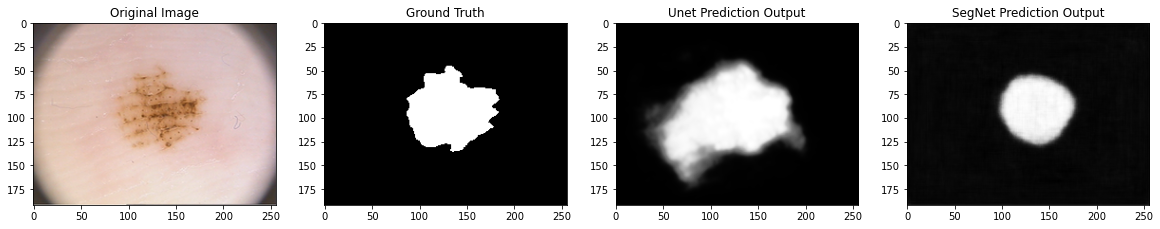

In [62]:
img_num = 48
img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

1/1 [==============================] - 0s 371ms/step


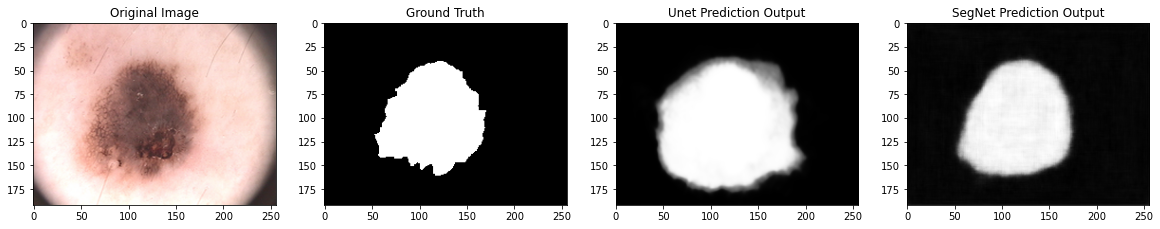

In [63]:
img_num = 29
img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

1/1 [==============================] - 0s 343ms/step


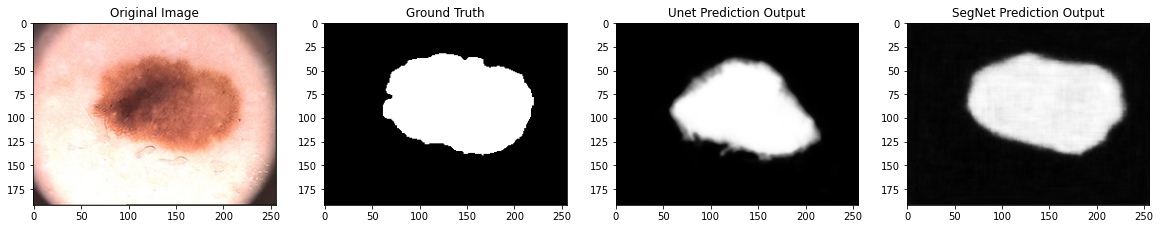

In [64]:
img_num = 21
img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

1/1 [==============================] - 0s 353ms/step


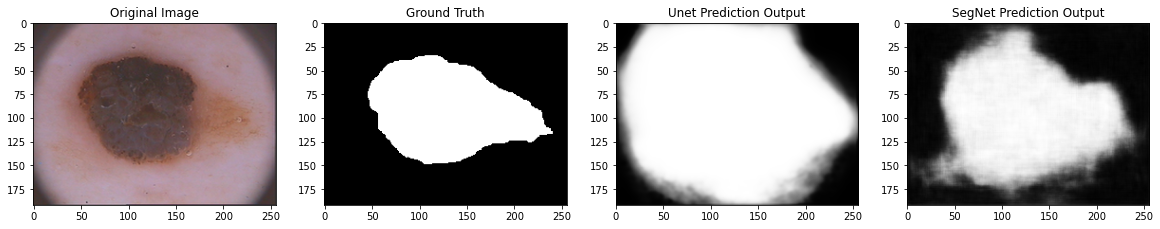

In [65]:
img_num = 11
img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

### Observation
- From the above results we can observe that Unet is better at keeping the detailed shape of the lesion but is prone to boundary noise very much.  
- On the other hand SegNet is not as accurate in shape but is very stable and less volatile in its predictions.

### Ensemble

#### Bagging
Bagging is a technique in which the results of the different models are averaged out to get more accurate results. We will manually implement this technique for each pixel.  

#### Post Processing
A simple post processing technique we will use is thresholding. Using a threshold of 0.7 which is an arbitrary value chosen from different values tried practically. Pixel having value greater than 0.7 will be changed to 1 whiile less than it will be switched to 0. This will also remove a lot of gray pixels.

In [67]:
def enhance(img):
    sub1 = (model_unet.predict(img.reshape(1,192,256,3))).flatten()
    sub2 = (model_segnet.predict(img.reshape(1,192,256,3))).flatten()
    sub = sub1[:]
    for i in range(len(sub)):
        sub[i] = (sub1[i] + sub2[i])/2
        
        if sub[i] > 0.7:
            sub[i] = 1
        else:
            sub[i] = 0

    return sub

1/1 [==============================] - 0s 377ms/step


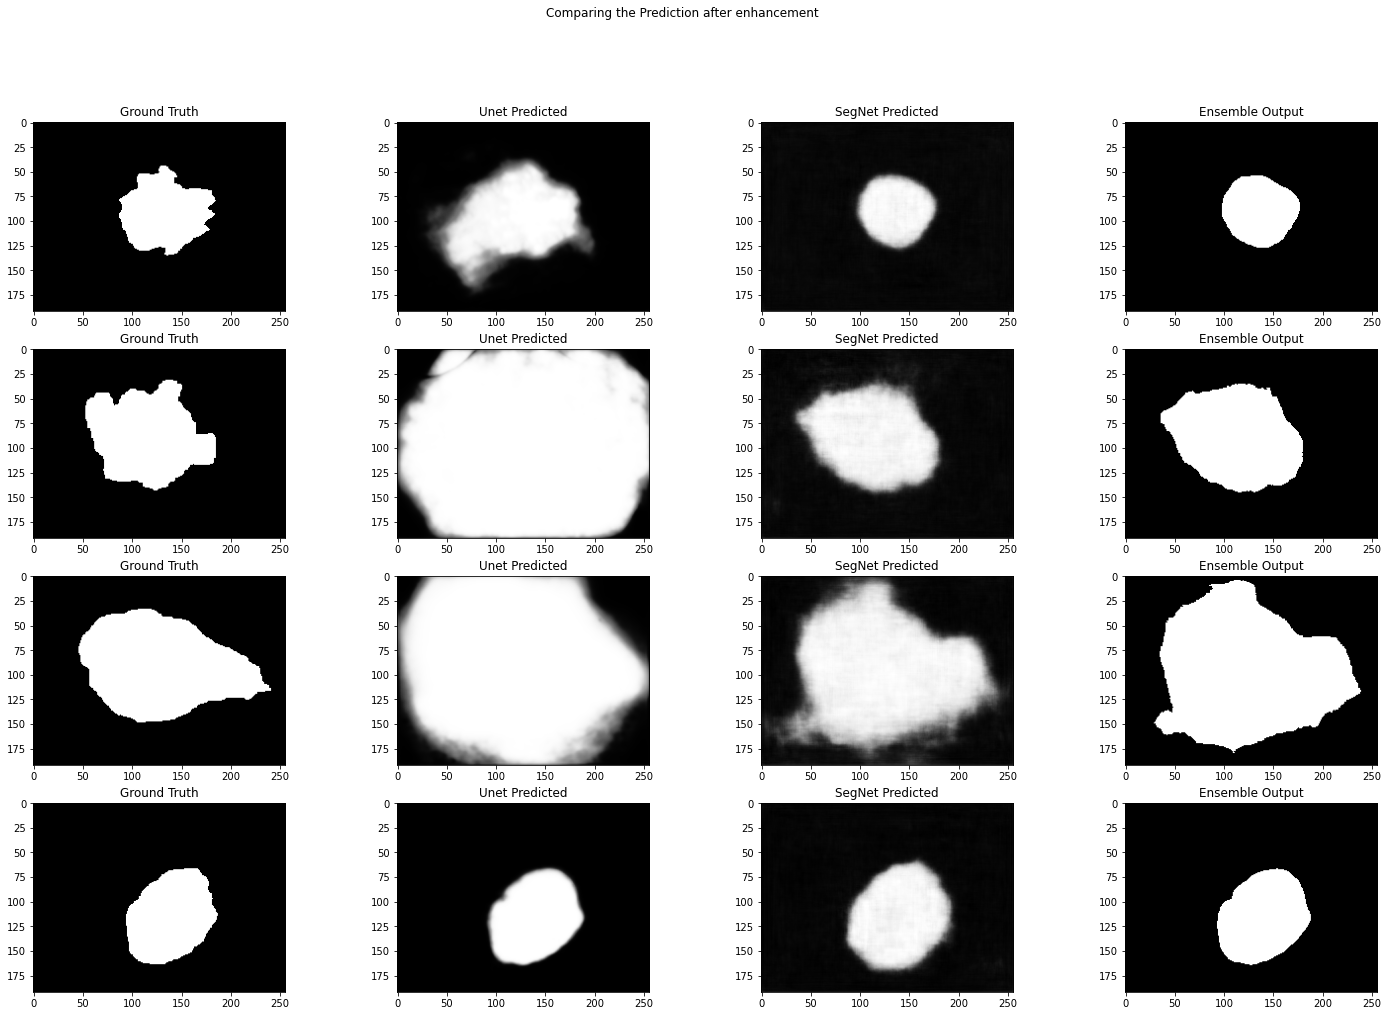

In [69]:
plt.figure(figsize=(25,16))
plt.suptitle('Comparing the Prediction after enhancement')

img_num = 48
plt.subplot(4,4,1)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,2)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,3)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,4)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')


img_num = 37
plt.subplot(4,4,5)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,6)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,7)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,8)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 11
plt.subplot(4,4,9)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,10)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,11)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,12)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 49
plt.subplot(4,4,13)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,14)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,15)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,16)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')
plt.show()

So we can see that our ensembled results have a good balance of more accurate boundaries of unet and less noisy predictions of SegNet